Test MSE: 0.004938769281722252
Test R²: 0.6130835640594012


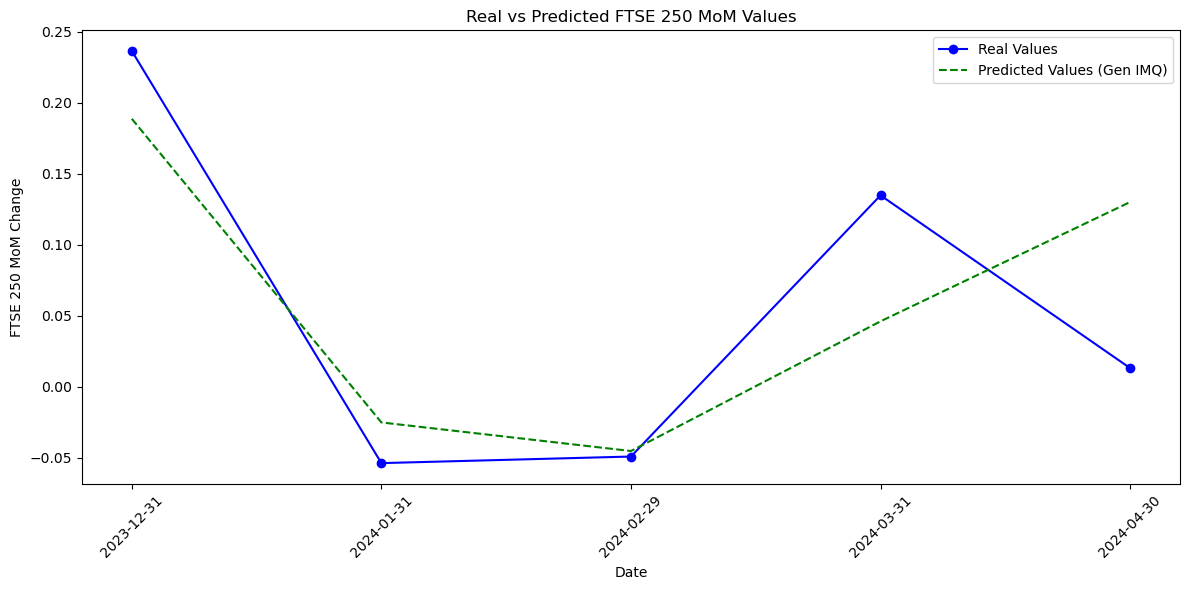

In [ ]:
# Inverse Multi-Quadric RBF-NN for Short-Term Prediction of FTSE 250
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, NormalizedKernelMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------
# Define Custom Kernel
# -----------------------

class GeneralizedInverseMultiquadricKernel(Kernel, NormalizedKernelMixin):
    """
    Generalized Inverse Multiquadric Kernel for use with GaussianProcessRegressor.
    K(x, y) = (||x - y||^2 + σ^2)^(-p)
    """
    def __init__(self, length_scale=1.0, sigma=1.0, power=1.0):
        self.length_scale = length_scale
        self.sigma = sigma
        self.power = power

    def __call__(self, X, Y=None):
        X = np.atleast_2d(X) / self.length_scale
        Y = X if Y is None else np.atleast_2d(Y) / self.length_scale
        dists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        return (dists + self.sigma ** 2) ** (-self.power)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# -----------------------
# Load and Preprocess Data
# -----------------------

# Load dataset
data = pd.read_csv('../data/monthly-data-m3.csv')  # Adjust path as needed
data.set_index('month', inplace=True)

# Drop unused variable
data = data.drop(columns=['M2'])

# Apply z-score normalisation and take first differences
data_diff = data.apply(lambda x: pd.Series(zscore(x))).diff().dropna()

# Define features and target
X = data_diff[['CPI', 'INT', 'EXCHG', 'M3']]
Y = data_diff['FTSE-250']

# -----------------------
# Train/Validation/Test Split
# -----------------------

n = len(X)
train_size = int(0.80 * n)
val_size = int(0.19 * n)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, Y_test = X[train_size + val_size:], Y[train_size + val_size:]

# -----------------------
# Fit GPR Model with Custom Kernel
# -----------------------

kernel = GeneralizedInverseMultiquadricKernel(length_scale=0.2, sigma=0.1, power=0.4)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

gpr.fit(X_train, Y_train)

Y_val_pred = gpr.predict(X_val)
Y_test_pred = gpr.predict(X_test)

# -----------------------
# Evaluate Performance
# -----------------------

mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f"Test MSE: {mse_test:.5f}")
print(f"Test R²: {r2_test:.5f}")

# -----------------------
# Plot Results
# -----------------------

plot_data = pd.DataFrame({
    'Date': data_diff.index[train_size + val_size:],
    'Real': Y_test,
    'Predicted': Y_test_pred
})

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Date'], plot_data['Real'], label='Real', marker='o', color='navy')
plt.plot(plot_data['Date'], plot_data['Predicted'], label='Predicted (Gen IMQ)', linestyle='--', color='darkorange')
plt.title('Short-Term Forecast: FTSE 250 MoM Change')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Δ (Standardised)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Test MSE: 0.026692804056986267
Test R²: 0.08704163414777488


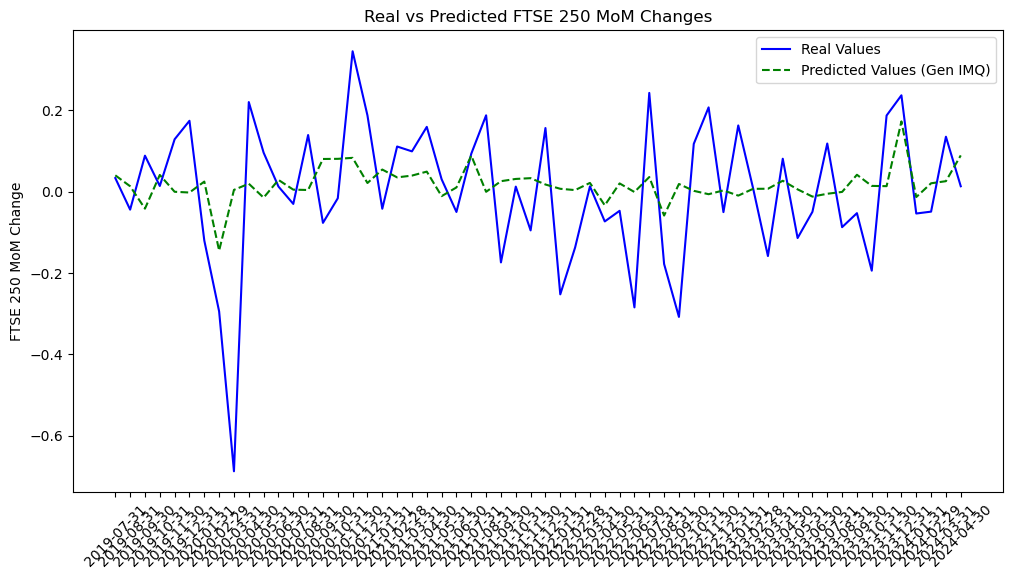

In [3]:
# Inverse Multi-Quadric RBF for long-term trend modelling 

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, NormalizedKernelMixin
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Define the Generalized Inverse Multiquadric Kernel
class GeneralizedInverseMultiquadricKernel(Kernel, NormalizedKernelMixin):
    def __init__(self, length_scale=0, sigma=1.0, power=1.0):
        self.length_scale = length_scale
        self.sigma = sigma
        self.power = power

    def __call__(self, X, Y=None):
        X = np.atleast_2d(X) / self.length_scale
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y) / self.length_scale
        dists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        return (dists + self.sigma ** 2) ** (-self.power)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# Define the Mean Function
class MeanFunction:
    def __init__(self, constant=0.0075, amplitude=0.05):
        self.constant = constant
        self.amplitude = amplitude

    def __call__(self, X):
        return self.constant + self.amplitude * (0.05 * np.sin(X[:, 0]) + 0.05 * np.cos(X[:, 0]))

# Load and preprocess data
data = pd.read_csv('monthly-data-m3.csv')
data.set_index('month', inplace=True)
data_normalised = data.apply(zscore)
data_normalised = data_normalised.drop(columns=['M2'])
data_normalised['FTSE-250'] = data_normalised['FTSE-250'].diff()
data_normalised['CPI'] = data_normalised['CPI'].diff()
data_normalised['INT'] = data_normalised['INT'].diff()
data_normalised['EXCHG'] = data_normalised['EXCHG'].diff()
data_normalised['M3'] = data_normalised['M3'].diff()
data_normalised = data_normalised.iloc[1:]

X = data_normalised[['CPI', 'INT', 'EXCHG', 'M3']]
Y = data_normalised['FTSE-250']

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_temp = X[:train_size], X[train_size:]
Y_train, Y_temp = Y[:train_size], Y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
Y_val, Y_test = Y_temp[:val_size], Y_temp[val_size:]

# Initialize the kernel and mean function
gen_imq_kernel = GeneralizedInverseMultiquadricKernel(length_scale=0.1, sigma=0.1, power=0.1)
mean_function = MeanFunction()

# Custom Kernel with Mean Function
class CustomKernelWithMean(Kernel, NormalizedKernelMixin):
    def __init__(self, base_kernel, mean_function):
        self.base_kernel = base_kernel
        self.mean_function = mean_function
    
    def __call__(self, X, Y=None):
        return self.base_kernel(X, Y)
    
    def diag(self, X):
        return self.base_kernel.diag(X)
    
    def is_stationary(self):
        return self.base_kernel.is_stationary()
    
    def mean_function(self, X):
        return self.mean_function(X)

# Initialize Custom Kernel
custom_kernel = CustomKernelWithMean(base_kernel=gen_imq_kernel, mean_function=mean_function)

# Initialize and fit the Gaussian Process Regressor with the custom kernel
gpr = GaussianProcessRegressor(kernel=custom_kernel, alpha=1e-05, normalize_y=True)
gpr.fit(X_train, Y_train)

# Predict on validation and test sets
Y_val_pred = gpr.predict(X_val)
Y_test_pred = gpr.predict(X_test)

# Evaluate the model
mse_val = mean_squared_error(Y_val, Y_val_pred)
r2_val = r2_score(Y_val, Y_val_pred)

mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f'Test MSE: {mse_test}')
print(f'Test R²: {r2_test}')

# Plot results
plot_data = pd.DataFrame({
    'Date': data_normalised.index[train_size + val_size:],
    'Real': Y_test,
    'Predicted': Y_test_pred
})

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Date'], plot_data['Real'], label='Real Values', color='blue')
plt.plot(plot_data['Date'], plot_data['Predicted'], label='Predicted Values (Gen IMQ)', color='green', linestyle='--')
plt.ylabel('FTSE 250 MoM Change')
plt.title('Real vs Predicted FTSE 250 MoM Changes')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.show()


Test MSE: 0.026692804056986267
Test R²: 0.08704163414777488
Training MSE: 2.6246763100521104e-10
Training R²: 0.9999999261333009


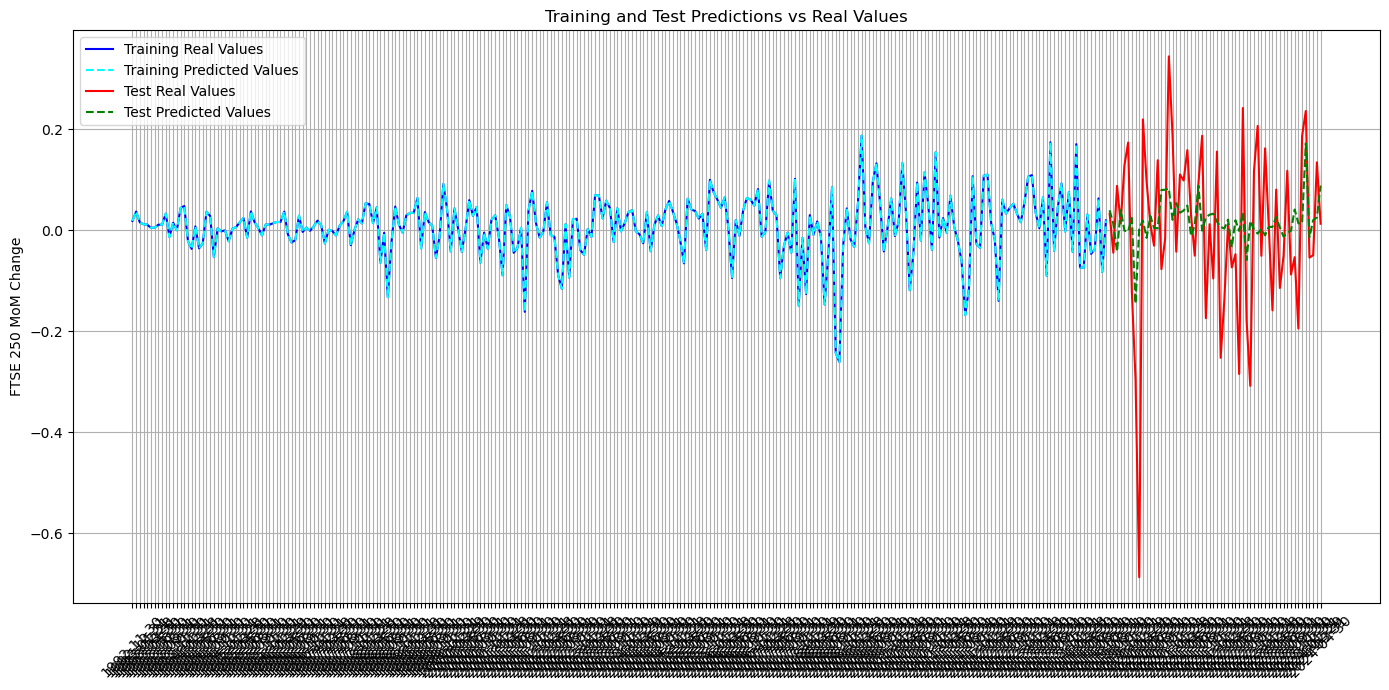

In [4]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, NormalizedKernelMixin
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Define the Generalized Inverse Multiquadric Kernel
class GeneralizedInverseMultiquadricKernel(Kernel, NormalizedKernelMixin):
    def __init__(self, length_scale=0, sigma=1.0, power=1.0):
        self.length_scale = length_scale
        self.sigma = sigma
        self.power = power

    def __call__(self, X, Y=None):
        X = np.atleast_2d(X) / self.length_scale
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y) / self.length_scale
        dists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        return (dists + self.sigma ** 2) ** (-self.power)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# Define the Mean Function
class MeanFunction:
    def __init__(self, constant=0.0075, amplitude=0.05):
        self.constant = constant
        self.amplitude = amplitude

    def __call__(self, X):
        return self.constant + self.amplitude * (0.05 * np.sin(X[:, 0]) + 0.05 * np.cos(X[:, 0]))

# Load and preprocess data
data = pd.read_csv('monthly-data-m3.csv')
data.set_index('month', inplace=True)
data_normalised = data.apply(zscore)
data_normalised = data_normalised.drop(columns=['M2'])
data_normalised['FTSE-250'] = data_normalised['FTSE-250'].diff()
data_normalised['CPI'] = data_normalised['CPI'].diff()
data_normalised['INT'] = data_normalised['INT'].diff()
data_normalised['EXCHG'] = data_normalised['EXCHG'].diff()
data_normalised['M3'] = data_normalised['M3'].diff()
data_normalised = data_normalised.iloc[1:]

X = data_normalised[['CPI', 'INT', 'EXCHG', 'M3']]
Y = data_normalised['FTSE-250']

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_temp = X[:train_size], X[train_size:]
Y_train, Y_temp = Y[:train_size], Y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
Y_val, Y_test = Y_temp[:val_size], Y_temp[val_size:]

# Initialize the kernel and mean function
gen_imq_kernel = GeneralizedInverseMultiquadricKernel(length_scale=0.1, sigma=0.1, power=0.1)
mean_function = MeanFunction()

# Custom Kernel with Mean Function
class CustomKernelWithMean(Kernel, NormalizedKernelMixin):
    def __init__(self, base_kernel, mean_function):
        self.base_kernel = base_kernel
        self.mean_function = mean_function
    
    def __call__(self, X, Y=None):
        return self.base_kernel(X, Y)
    
    def diag(self, X):
        return self.base_kernel.diag(X)
    
    def is_stationary(self):
        return self.base_kernel.is_stationary()
    
    def mean_function(self, X):
        return self.mean_function(X)

# Initialize Custom Kernel
custom_kernel = CustomKernelWithMean(base_kernel=gen_imq_kernel, mean_function=mean_function)

# Initialize and fit the Gaussian Process Regressor with the custom kernel
gpr = GaussianProcessRegressor(kernel=custom_kernel, alpha=1e-05, normalize_y=True)
gpr.fit(X_train, Y_train)

# Predict on training, validation, and test sets
Y_train_pred = gpr.predict(X_train)
Y_val_pred = gpr.predict(X_val)
Y_test_pred = gpr.predict(X_test)

# Evaluate the model
mse_val = mean_squared_error(Y_val, Y_val_pred)
r2_val = r2_score(Y_val, Y_val_pred)

mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f'Test MSE: {mse_test}')
print(f'Test R²: {r2_test}')

mse_train = mean_squared_error(Y_train, Y_train_pred)
r2_train = r2_score(Y_train, Y_train_pred)

print(f'Training MSE: {mse_train}')
print(f'Training R²: {r2_train}')

# Plot results
plot_data = pd.DataFrame({
    'Date': data_normalised.index[train_size + val_size:],
    'Real': Y_test,
    'Predicted': Y_test_pred
})

train_plot_data = pd.DataFrame({
    'Date': data_normalised.index[:train_size],
    'Real': Y_train,
    'Predicted': Y_train_pred
})

plt.figure(figsize=(14, 7))

# Plot Training Data
plt.plot(train_plot_data['Date'], train_plot_data['Real'], label='Training Real Values', color='blue', linestyle='-', linewidth=1.5)
plt.plot(train_plot_data['Date'], train_plot_data['Predicted'], label='Training Predicted Values', color='cyan', linestyle='--', linewidth=1.5)

# Plot Validation and Test Data
plt.plot(plot_data['Date'], plot_data['Real'], label='Test Real Values', color='red', linestyle='-', linewidth=1.5)
plt.plot(plot_data['Date'], plot_data['Predicted'], label='Test Predicted Values', color='green', linestyle='--', linewidth=1.5)

plt.ylabel('FTSE 250 MoM Change')
plt.title('Training and Test Predictions vs Real Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plot_data.to_csv('trainingtest.csv', index=False)